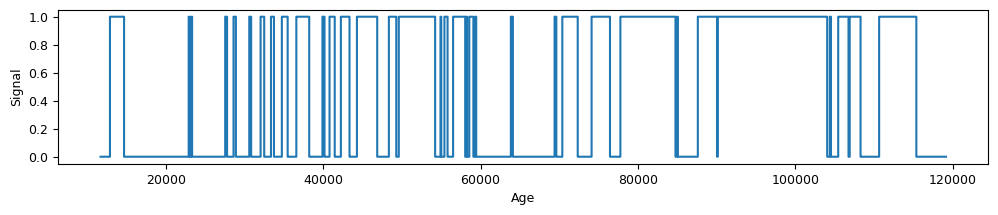

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt





import pandas as pd
import numpy as np

def interpolate_df(df, interval):
    # Get column names
    time_col = df.columns[0]
    value_col = df.columns[1]
    
    # Create new regular time grid
    time_min = df[time_col].min()
    time_max = df[time_col].max()
    new_time = np.arange(time_min, time_max + interval, interval)
    
    # Interpolate values onto new time grid
    new_values = np.interp(new_time, df[time_col], df[value_col])
    
    # # Create new dataframe
    # df_interp = pd.DataFrame({
    #     time_col: new_time,
    #     value_col: new_values
    # })
    # return df_interp, using the same column names as the original dataframe
    df_interp = pd.DataFrame({time_col: new_time, value_col: new_values})
    
    return df_interp








# Given ground truth intervals for the low phase (-1)
gs_data = {
    "start": [11703, 14692, 23020, 23340, 27780, 28900, 30840, 32500, 33740, 35480,
              38220, 40160, 41460, 43340, 46860, 49280, 54220, 55000, 55800, 58040,
              58280, 59080, 59440, 64100, 69620, 72340, 76440, 84760, 85060, 90040,
              104040,104520,106750,108280,115370],
    "end":   [12896, 22900, 23220, 27540, 28600, 30600, 32040, 33360, 34740, 36580,
              39900, 40800, 42240, 44280, 48340, 49600, 54900, 55400, 56500, 58160,
              58560, 59300, 63840, 69400, 70380, 74100, 77760, 84960, 87600, 90140,
              104380,105440,106900,110640,119140]
}

# Create an age vector (baseline resolution e.g. every 10 years)
ages = np.arange(11703, 119140, 1)

# Initialize signal at +1
signal = np.ones_like(ages)

# Flip to -1 during the specified low-phase intervals
for start, end in zip(gs_data["start"], gs_data["end"]):
    mask = (ages >= start) & (ages <= end)
    signal[mask] = 0

# Build a DataFrame for clarity
df_sq = pd.DataFrame({"age": ages, "sq": signal})

# Plot the irregular square wave
plt.figure(figsize=(12, 2))
plt.step(df_sq["age"], df_sq["sq"], where="post")
plt.xlabel("Age")
plt.ylabel("Signal")
# plt.title("Irregular Square Wave Signal")
plt.show()



import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)





# read the filtered data
df_filt_ch4 = pd.read_csv('D:/VScode/bipolar_seesaw_CCM/filtered_data/CH4_AICC2023_filtered.csv')
df_filt_d18O = pd.read_csv('D:/VScode/bipolar_seesaw_CCM/filtered_data/Speleothem_d18O_filtered.csv')


#read the filtered d18O data
df_filt_d18O_B = pd.read_csv(r'D:\VScode\bipolar_seesaw_CCM\filtered_data\MD01-2444_339-U1385_benthic_d18O_hp_filt.csv')
# read the filtered data
df_filt_d18O_fuji = pd.read_csv(r"D:\VScode\bipolar_seesaw_CCM\filtered_data\Fuji_d18O_filtered.csv")

Text(0.5, 1.0, 'High-pass Filtered CH4 and d18O Data')

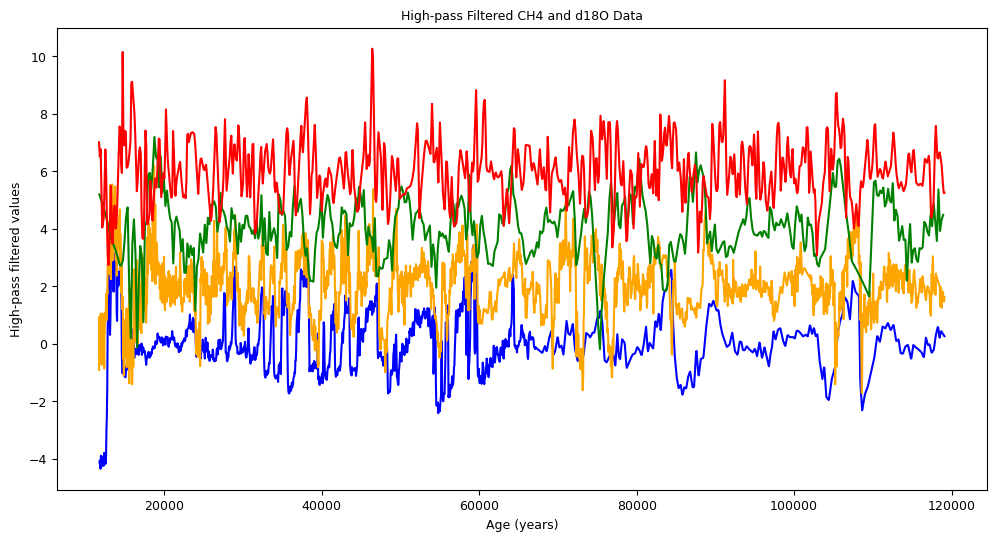

In [46]:
from scipy.stats import zscore

df_filt_ch4 = interpolate_df(df_filt_ch4, 50)
df_filt_d18O = interpolate_df(df_filt_d18O, 30)
df_filt_d18O_B = interpolate_df(df_filt_d18O_B, 50)
df_filt_d18O_fuji = interpolate_df(df_filt_d18O_fuji, 100)


# crop the two data for age <120000
df_filt_ch4 = df_filt_ch4[df_filt_ch4['age'] < 119140]
df_filt_d18O = df_filt_d18O[df_filt_d18O['age'] < 119140]
df_filt_d18O_B = df_filt_d18O_B[df_filt_d18O_B['age'] < 119140]
df_filt_d18O_fuji = df_filt_d18O_fuji[df_filt_d18O_fuji['age'] < 119140]

# crop for age >10000
df_filt_ch4 = df_filt_ch4[df_filt_ch4['age'] > 11703]
df_filt_d18O = df_filt_d18O[df_filt_d18O['age'] > 11703]
df_filt_d18O_B = df_filt_d18O_B[df_filt_d18O_B['age'] > 11703]
df_filt_d18O_fuji = df_filt_d18O_fuji[df_filt_d18O_fuji['age'] > 11703]

# 3) Plot the high-pass filtered data
plt.figure(figsize=(12, 6))
plt.plot(df_filt_ch4['age'], zscore(df_filt_ch4['filt_ch4']), label='CH4', color='blue')
plt.plot(df_filt_d18O['age'], zscore(df_filt_d18O['filt_d18O'])+2, label='Speleothem d18O', color='orange')
plt.plot(df_filt_d18O_B['age'], zscore(df_filt_d18O_B['filt_d18O'])+4, label='Benthic d18O', color='green')
plt.plot(df_filt_d18O_fuji['age'], zscore(df_filt_d18O_fuji['filt_d18O'])+6, label='Fuji d18O', color='red')
plt.xlabel('Age (years)')
plt.ylabel('High-pass filtered values')
plt.title('High-pass Filtered CH4 and d18O Data')

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_DO_with_shading(df_sq, df_data, data_col, median_val=None,
                         color_stadial='lightblue', alpha_stadial=0.3,
                         color_interstadial='moccasin', alpha_interstadial=0.3,
                         color_up='red', color_down='blue',
                         figsize=(20,3), dpi=300, invert_x=True):
    """
    Plot NGRIP stadials (sq==0) and interstadials (sq==1) as background strips,
    then overlay data with median-based red/blue shading.

    Parameters
    ----------
    df_sq : pd.DataFrame
        Columns: 'age', 'sq' (0=stadial, 1=interstadial).
    df_data : pd.DataFrame
        Columns: 'age', data_col.
    data_col : str
        Column name for data to plot (e.g. 'filt_ch4').
    median_val : float, optional
        Precomputed median of df_data[data_col]. If None, computed automatically.
    color_stadial : color
        Fill color for stadial intervals (sq==0).
    alpha_stadial : float
        Transparency for stadial shading.
    color_interstadial : color
        Fill color for interstadial intervals (sq==1).
    alpha_interstadial : float
        Transparency for interstadial shading.
    color_up, color_down : color
        Shading colors for data above/below median.
    figsize : tuple
        Figure size.
    invert_x : bool
        If True, invert x-axis (oldest on left).

    Returns
    -------
    fig, ax : matplotlib Figure and Axes objects.
    """
    # Sort by age
    df_sq = df_sq.sort_values('age').reset_index(drop=True)
    df = df_data.sort_values('age').reset_index(drop=True)

    # Compute median if not provided
    if median_val is None:
        median_val = np.median(df[data_col])

    # Extract arrays
    ages = df_sq['age'].values
    states = df_sq['sq'].values.astype(int)

    # Identify run boundaries where state changes
    change_idx = np.where(np.diff(states) != 0)[0]
    boundaries = np.concatenate(([0], change_idx + 1, [len(states)]))

    # Set up plot
    fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)

    # Draw background strips
    for i in range(len(boundaries)-1):
        start_idx = boundaries[i]
        end_idx = boundaries[i+1] - 1
        s_age = ages[start_idx]
        e_age = ages[end_idx]
        state = states[start_idx]
        if state == 0:
            ax.axvspan(s_age, e_age,
                       color=color_stadial,
                       alpha=alpha_stadial,
                       zorder=0)
        else:
            ax.axvspan(s_age, e_age,
                       color=color_interstadial,
                       alpha=alpha_interstadial,
                       zorder=0)

    # Plot data line
    ax.plot(df['age'], df[data_col], color='k', lw=1)

    # Median line
    ax.axhline(median_val, color='k', linestyle='--', lw=1)

    # Fill above median
    ax.fill_between(df['age'], median_val, df[data_col],
                    where=(df[data_col] >= median_val),
                    interpolate=True, color=color_up, alpha=0.4)

    # Fill below median
    ax.fill_between(df['age'], median_val, df[data_col],
                    where=(df[data_col] <= median_val),
                    interpolate=True, color=color_down, alpha=0.4)

    ax.set_xlabel('Age (years BP)')
    ax.set_ylabel(data_col)
    ax.set_title(f"{data_col} with NGRIP stadials/interstadials & median shading")
    # set x-axis limits
    ax.set_xlim(df['age'].min(), df['age'].max())

    if invert_x:
        ax.invert_xaxis()

    plt.tight_layout()
    return fig, ax

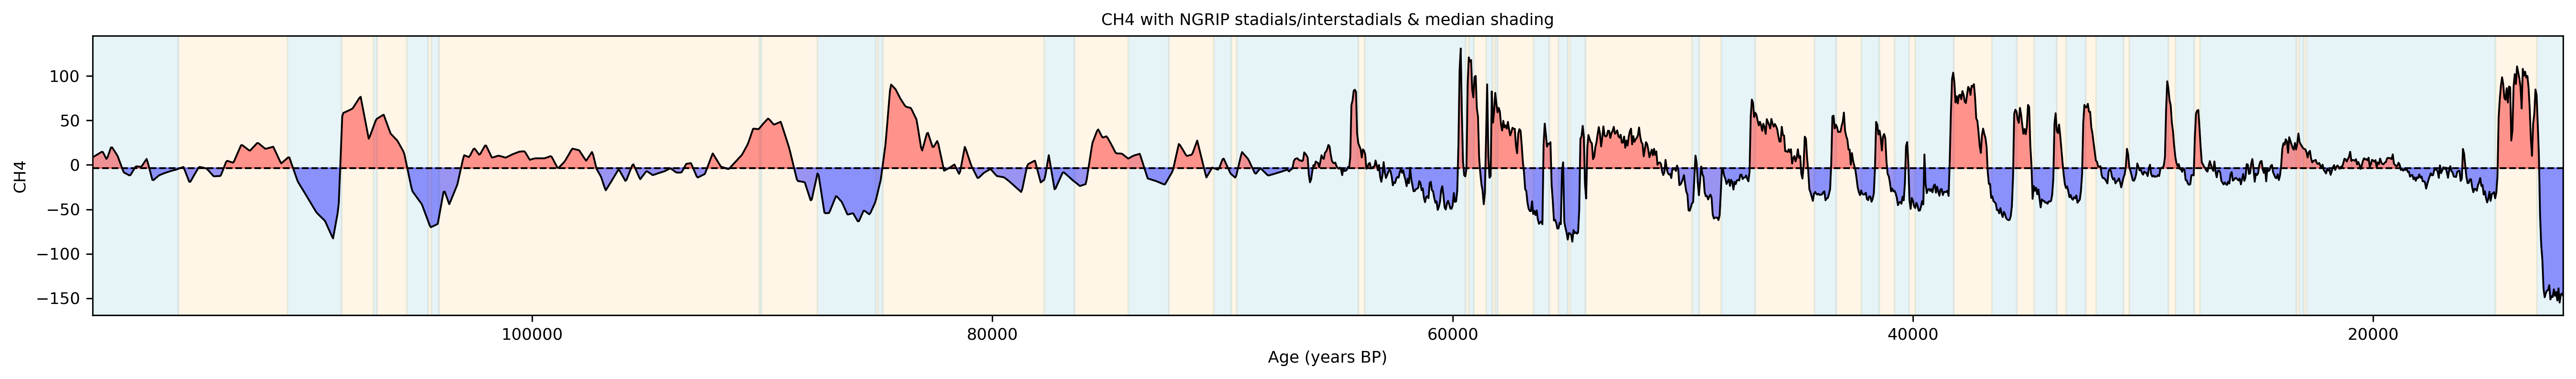

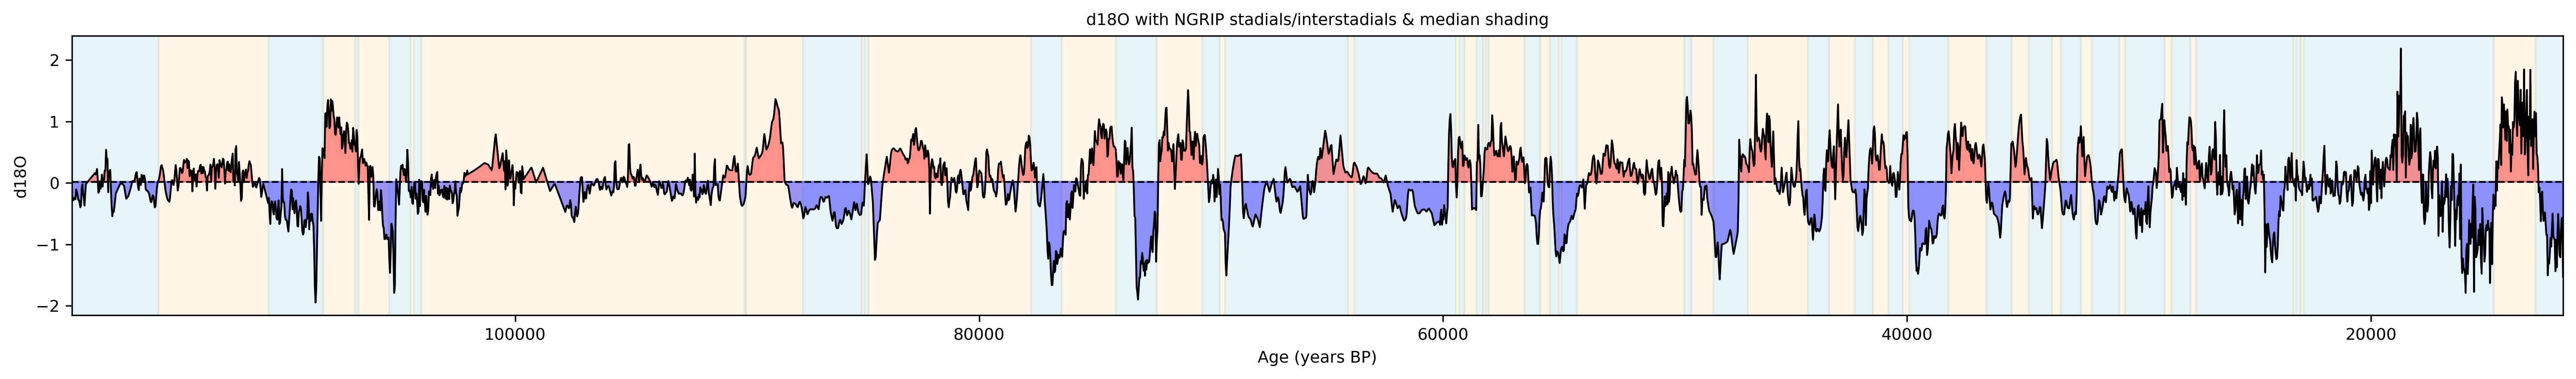

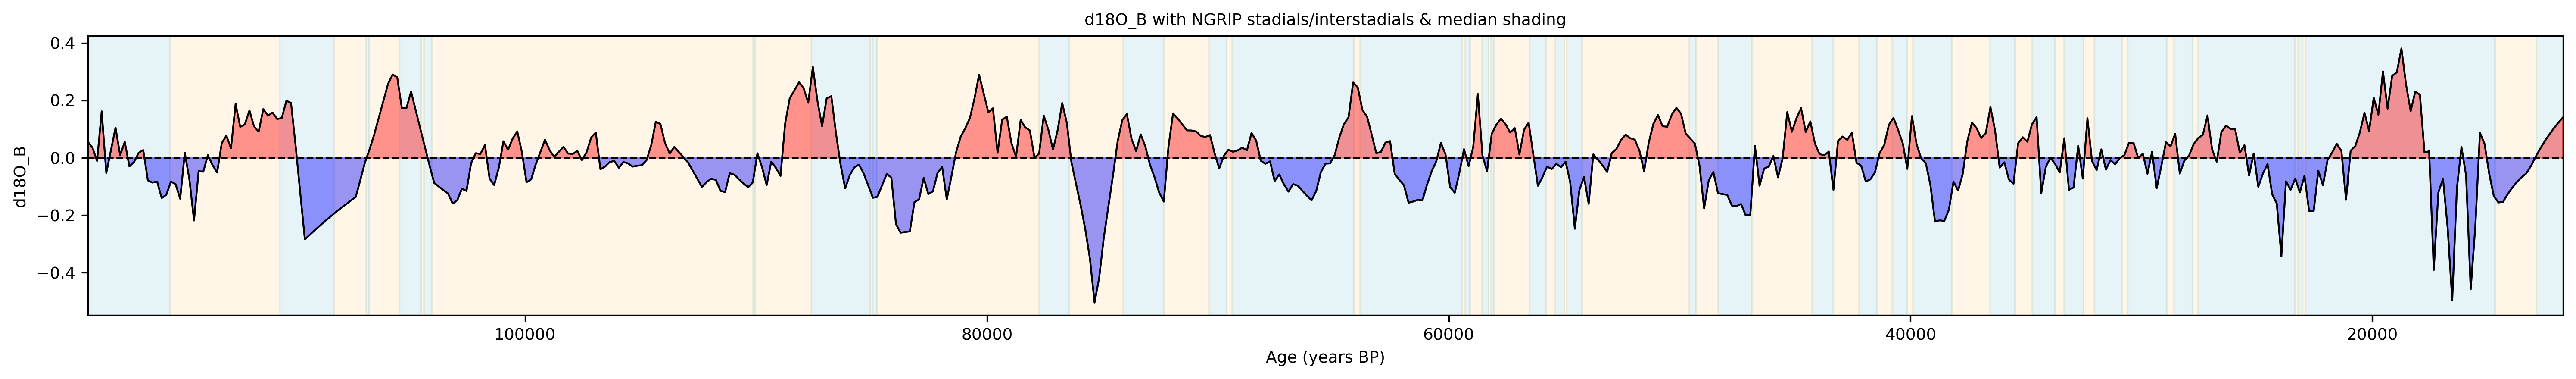

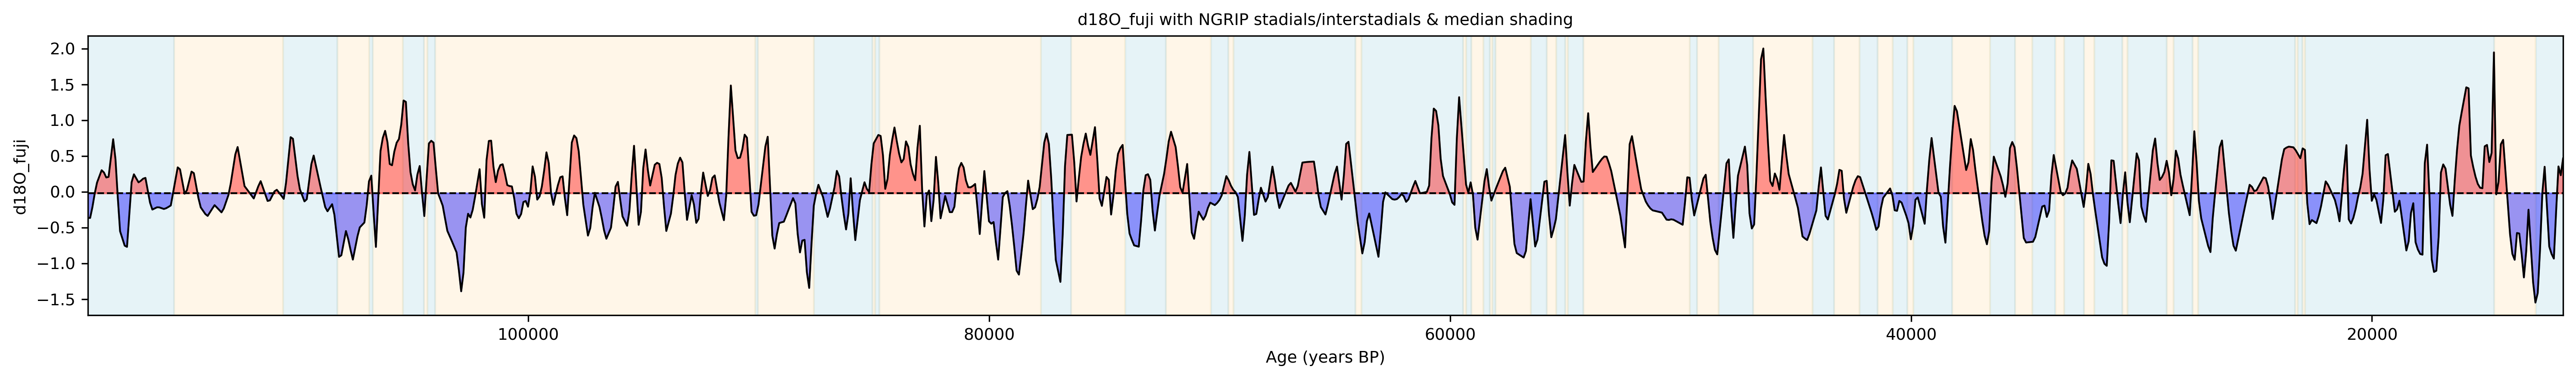

In [51]:

fig, ax = plot_DO_with_shading(
    df_sq,
    df_filt_ch4.copy().rename(columns={'filt_ch4':'CH4'}), 
    data_col='CH4'
)
plt.show()


fig, ax = plot_DO_with_shading(
    df_sq,
    df_filt_d18O.copy().rename(columns={'filt_d18O':'d18O'}), 
    data_col='d18O'
)
plt.show()

fig, ax = plot_DO_with_shading(
    df_sq,
    df_filt_d18O_B.copy().rename(columns={'filt_d18O':'d18O_B'}), 
    data_col='d18O_B'
)
plt.show()
fig, ax = plot_DO_with_shading(
    df_sq,
    df_filt_d18O_fuji.copy().rename(columns={'filt_d18O':'d18O_fuji'}), 
    data_col='d18O_fuji'
)
plt.show()

In [64]:
import numpy as np
import matplotlib.pyplot as plt

def compute_transition_stats(
    df_data,       # DataFrame with 'age' and your data column
    data_col,      # name of the column in df_data (e.g. 'filt_ch4')
    df_ref,        # Reference DataFrame with 'age' and 'sq'
    tol=100,       # tolerance window in same units as 'age'
    plot=True
):
    """
    1) Binarize df_data around its median to create sq flags.
    2) Count and print #transitions in df_data and df_ref.
    3) For each NGRIP transition, test if there's any df_data transition 
       within ±tol. Print the count and percentage.
    4) For each NGRIP transition, find the distance to the nearest 
       df_data transition and (optional) plot its histogram.

    Returns
    -------
    trans_data : np.ndarray    # ages of transitions in the input data
    trans_ref  : np.ndarray    # ages of transitions in the reference data
    dists      : np.ndarray    # nearest‐neighbor distances (one per ref transition)
    """
    # 1) Binarize the input data around its median
    median_val = df_data[data_col].median()
    df_input = df_data.copy()
    df_input['sq'] = (df_input[data_col] >= median_val).astype(int)

    # 2) Extract transition ages
    trans_data = df_input.loc[df_input['sq'].diff().fillna(0) != 0, 'age'].values
    trans_ref  = df_ref.loc[df_ref['sq'].diff().fillna(0) != 0, 'age'].values

    # Sort them (good practice for nearest‐neighbor)
    trans_data = np.sort(trans_data)
    trans_ref  = np.sort(trans_ref)

    n_data = len(trans_data)
    n_ref  = len(trans_ref)
    print(f"Input-data transitions:     {n_data}")
    print(f"NGRIP-reference transitions: {n_ref}")

    # 3) Count how many ref transitions have at least one data transition within ±tol
    matched = []
    for t in trans_ref:
        # mask of data transitions inside [t-tol, t+tol]
        in_window = (trans_data >= t - tol) & (trans_data <= t + tol)
        # print(in_window.any())
        matched.append(in_window.any())

    n_matched  = sum(matched)
    pct_matched = 100 * n_matched / n_ref
    print(f"\nOf the {n_ref} NGRIP transitions, {n_matched} "
          f"({pct_matched:.1f}%) lie within ±{tol} of a data transition.")

    # 4) For each ref transition, compute distance to the nearest data transition
    dists = np.array([np.min(np.abs(trans_data - t)) for t in trans_ref])

    if plot:
        plt.figure(figsize=(6,4))
        plt.hist(dists, bins=30, edgecolor='k')
        plt.xlabel('Distance to nearest data transition')
        # show median
        median_dist = np.median(dists)
        plt.axvline(median_dist, color='r', linestyle='--', label=f'Median: {median_dist:.1f}')
        plt.ylabel('Count')
        plt.title('Histogram of NGRIP→data transition distances')
        plt.legend()
        plt.tight_layout()
        plt.show()

    return pct_matched, trans_data, trans_ref, np.median(dists)



Input-data transitions:     149
NGRIP-reference transitions: 68

Of the 68 NGRIP transitions, 53 (77.9%) lie within ±500 of a data transition.


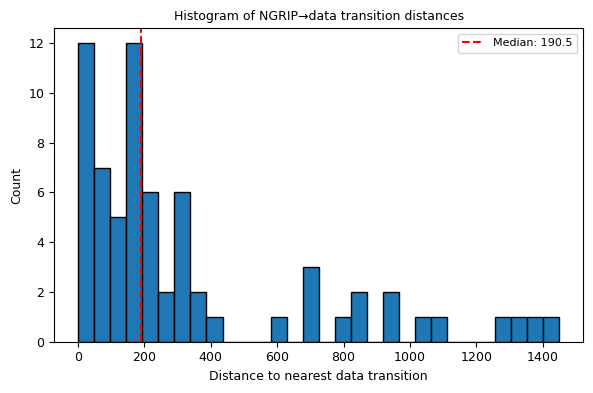

Input-data transitions:     374
NGRIP-reference transitions: 68

Of the 68 NGRIP transitions, 63 (92.6%) lie within ±500 of a data transition.


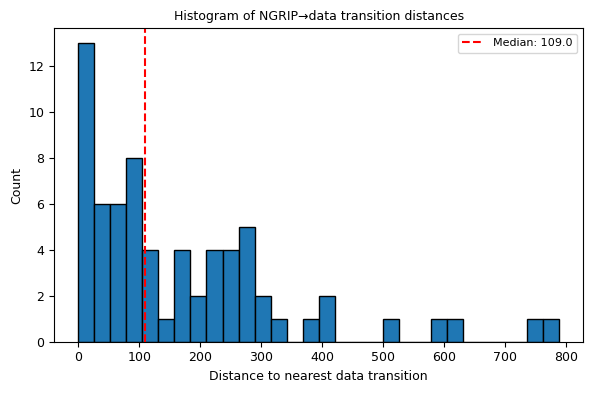

Input-data transitions:     104
NGRIP-reference transitions: 68

Of the 68 NGRIP transitions, 46 (67.6%) lie within ±500 of a data transition.


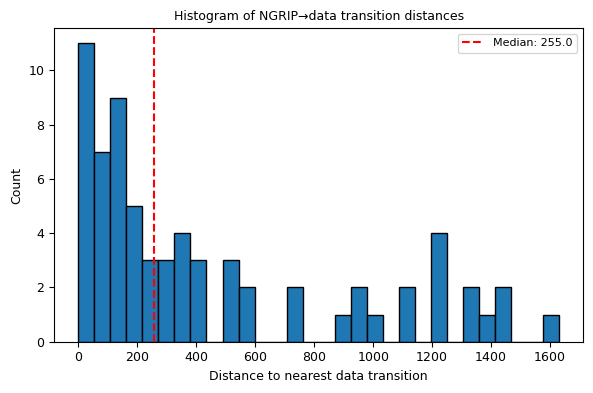

Input-data transitions:     189
NGRIP-reference transitions: 68

Of the 68 NGRIP transitions, 60 (88.2%) lie within ±500 of a data transition.


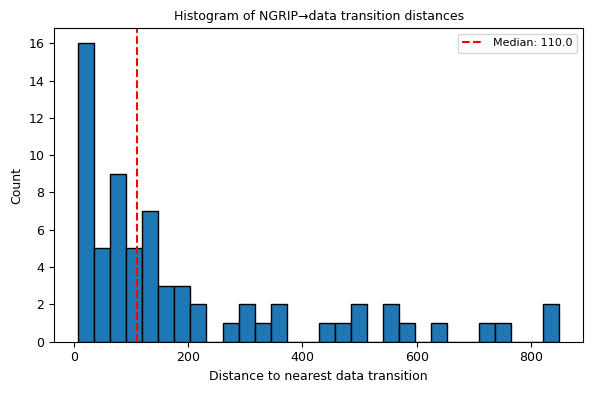

In [55]:

pct_matched_ch4, trans_ch4, trans_ng, distances_ch4 = compute_transition_stats(
    df_filt_ch4.copy(),
    data_col='filt_ch4',
    df_ref=df_sq,
    tol=500,
    plot=True
)

pct_matched_d18O, trans_d18O, trans_ng, distances_d18O = compute_transition_stats(
    df_filt_d18O.copy(),
    data_col='filt_d18O',
    df_ref=df_sq,
    tol=500,
    plot=True
)

pct_matched_d18O_B, trans_d18O_B,trans_ng, distances_d18O_B = compute_transition_stats(
    df_filt_d18O_B.copy(),
    data_col='filt_d18O',
    df_ref=df_sq,
    tol=500,
    plot=True
)

pct_matched_d18O_fuji,trans_d18O_fuji, trans_ng, distances_d18O_fuji = compute_transition_stats(
    df_filt_d18O_fuji.copy(),
    data_col='filt_d18O',
    df_ref=df_sq,
    tol=500,
    plot=True
)

Input-data transitions:     147
NGRIP-reference transitions: 68

Of the 68 NGRIP transitions, 53 (77.9%) lie within ±500 of a data transition.
Input-data transitions:     374
NGRIP-reference transitions: 68

Of the 68 NGRIP transitions, 63 (92.6%) lie within ±500 of a data transition.
Input-data transitions:     102
NGRIP-reference transitions: 68

Of the 68 NGRIP transitions, 45 (66.2%) lie within ±500 of a data transition.
Input-data transitions:     191
NGRIP-reference transitions: 68

Of the 68 NGRIP transitions, 58 (85.3%) lie within ±500 of a data transition.
Input-data transitions:     145
NGRIP-reference transitions: 68

Of the 68 NGRIP transitions, 53 (77.9%) lie within ±500 of a data transition.
Input-data transitions:     348
NGRIP-reference transitions: 68

Of the 68 NGRIP transitions, 63 (92.6%) lie within ±500 of a data transition.
Input-data transitions:     102
NGRIP-reference transitions: 68

Of the 68 NGRIP transitions, 45 (66.2%) lie within ±500 of a data transition.

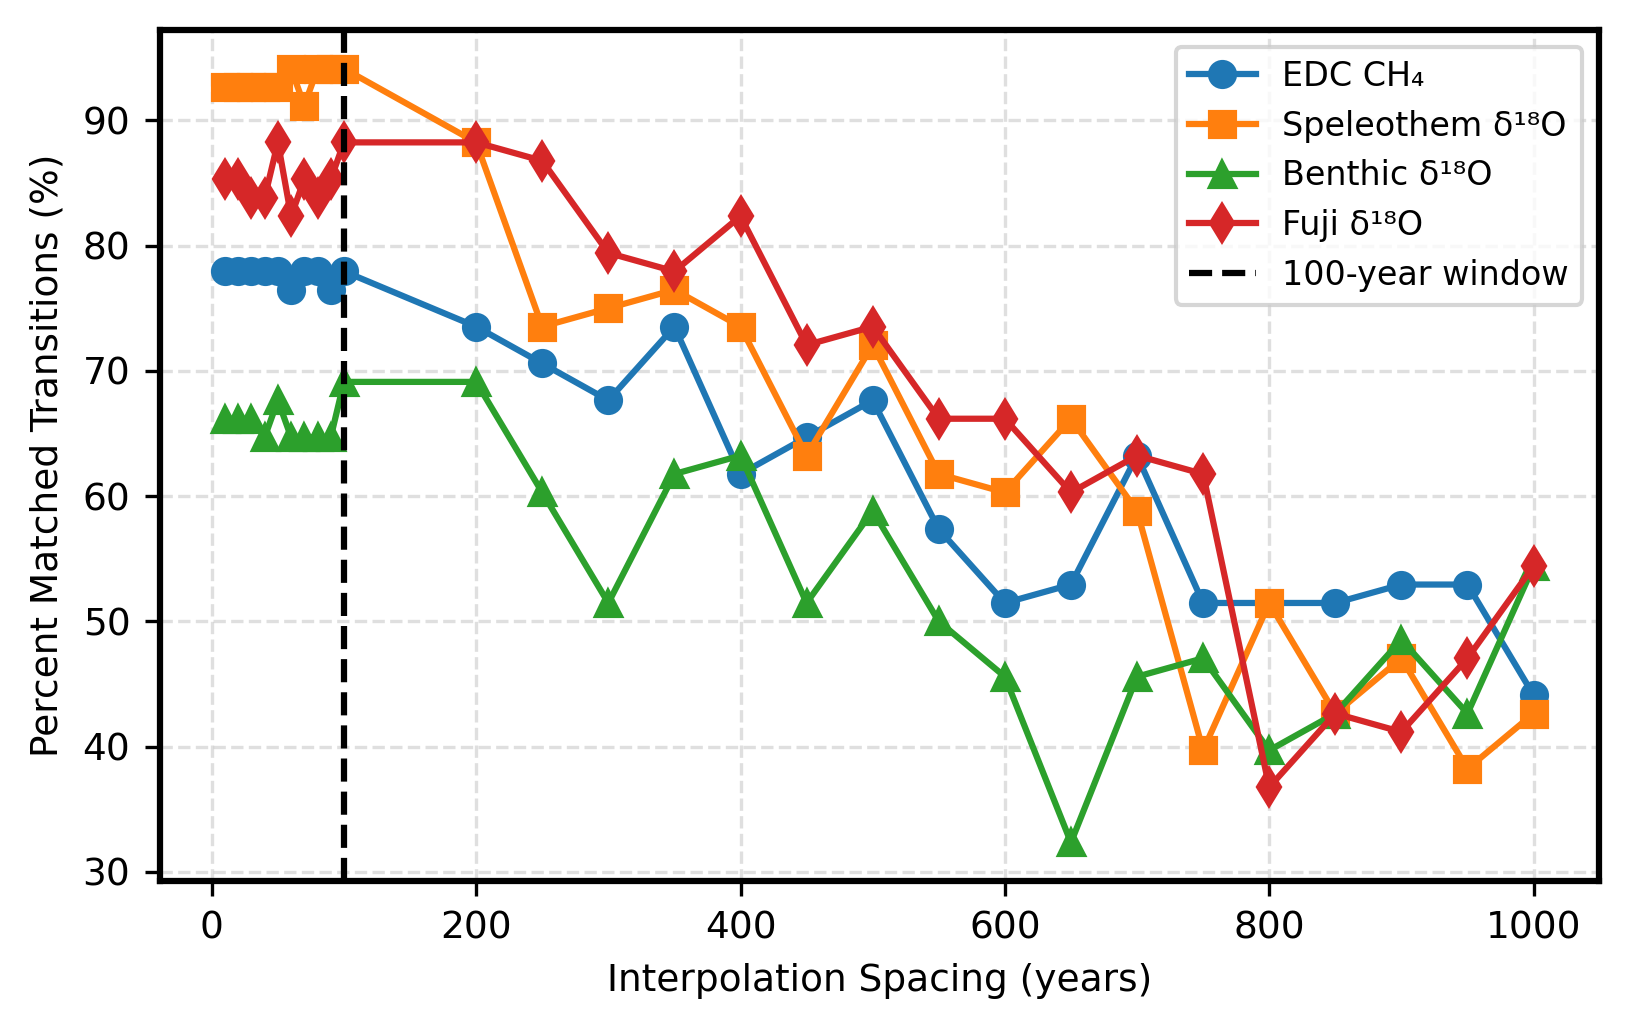

In [62]:
import numpy as np
import matplotlib.pyplot as plt

# Define interpolation window lengths: 10–100 by 10, then 200–1000 by 100
lengths = list(range(10, 101, 10)) + list(range(200, 1001, 50))

# Prepare result containers
results = {
    'CH4': [],
    'd18O': [],
    'd18O_B': [],
    'd18O_fuji': []
}

# Loop through each interpolation length
for L in lengths:
    # Interpolate each dataset
    df1 = interpolate_df(df_filt_ch4, L)
    df2 = interpolate_df(df_filt_d18O, L)
    df3 = interpolate_df(df_filt_d18O_B, L)
    df4 = interpolate_df(df_filt_d18O_fuji, L)

    # Crop to your age window [11703, 119140]
    for df in (df1, df2, df3, df4):
        df = df[(df['age'] > 11703) & (df['age'] < 119140)]

    # Compute matching percentage (suppress the histogram)
    pct1, *_ = compute_transition_stats(df1, 'filt_ch4', df_sq, tol=500, plot=False)
    pct2, *_ = compute_transition_stats(df2, 'filt_d18O', df_sq, tol=500, plot=False)
    pct3, *_ = compute_transition_stats(df3, 'filt_d18O', df_sq, tol=500, plot=False)
    pct4, *_ = compute_transition_stats(df4, 'filt_d18O', df_sq, tol=500, plot=False)

    # Store
    results['CH4'].append(pct1)
    results['d18O'].append(pct2)
    results['d18O_B'].append(pct3)
    results['d18O_fuji'].append(pct4)

# Plot all four series
plt.figure(figsize=(5.5, 3.5), dpi=300)
plt.plot(lengths, results['CH4'], marker='o', label='EDC CH₄')
plt.plot(lengths, results['d18O'], marker='s', label='Speleothem δ¹⁸O')
plt.plot(lengths, results['d18O_B'], marker='^', label='Benthic δ¹⁸O')
plt.plot(lengths, results['d18O_fuji'], marker='d', label='Fuji δ¹⁸O')

# plot a vertical black line at 100
plt.axvline(x=100, color='black', linestyle='--', linewidth=1.5, label='100-year window')

# loop through all spines and set the line width of spines to 1.5 
for spine in plt.gca().spines.values():
    spine.set_linewidth(1.5)




plt.xlabel('Interpolation Spacing (years)')
plt.ylabel('Percent Matched Transitions (%)')
# plt.title('Effect of Interpolation Window Length on % Matched Transitions')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Input-data transitions:     147
NGRIP-reference transitions: 68

Of the 68 NGRIP transitions, 53 (77.9%) lie within ±500 of a data transition.
Input-data transitions:     374
NGRIP-reference transitions: 68

Of the 68 NGRIP transitions, 63 (92.6%) lie within ±500 of a data transition.
Input-data transitions:     102
NGRIP-reference transitions: 68

Of the 68 NGRIP transitions, 45 (66.2%) lie within ±500 of a data transition.
Input-data transitions:     191
NGRIP-reference transitions: 68

Of the 68 NGRIP transitions, 58 (85.3%) lie within ±500 of a data transition.
Input-data transitions:     145
NGRIP-reference transitions: 68

Of the 68 NGRIP transitions, 53 (77.9%) lie within ±500 of a data transition.
Input-data transitions:     348
NGRIP-reference transitions: 68

Of the 68 NGRIP transitions, 63 (92.6%) lie within ±500 of a data transition.
Input-data transitions:     102
NGRIP-reference transitions: 68

Of the 68 NGRIP transitions, 45 (66.2%) lie within ±500 of a data transition.

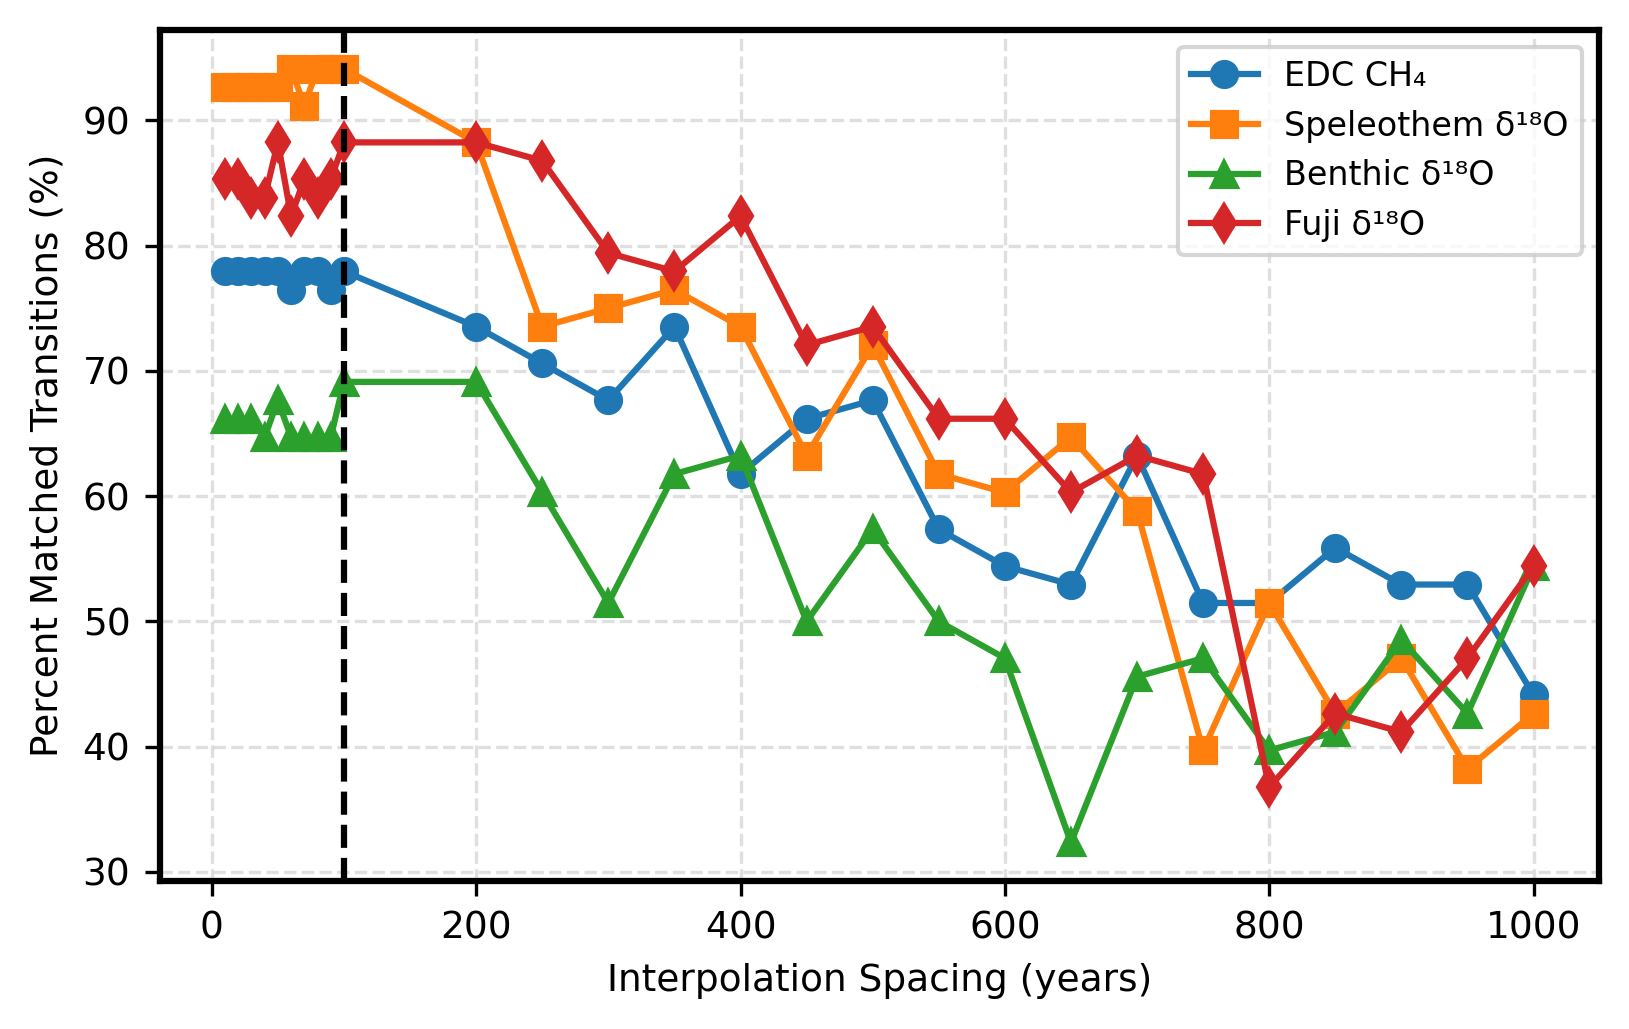

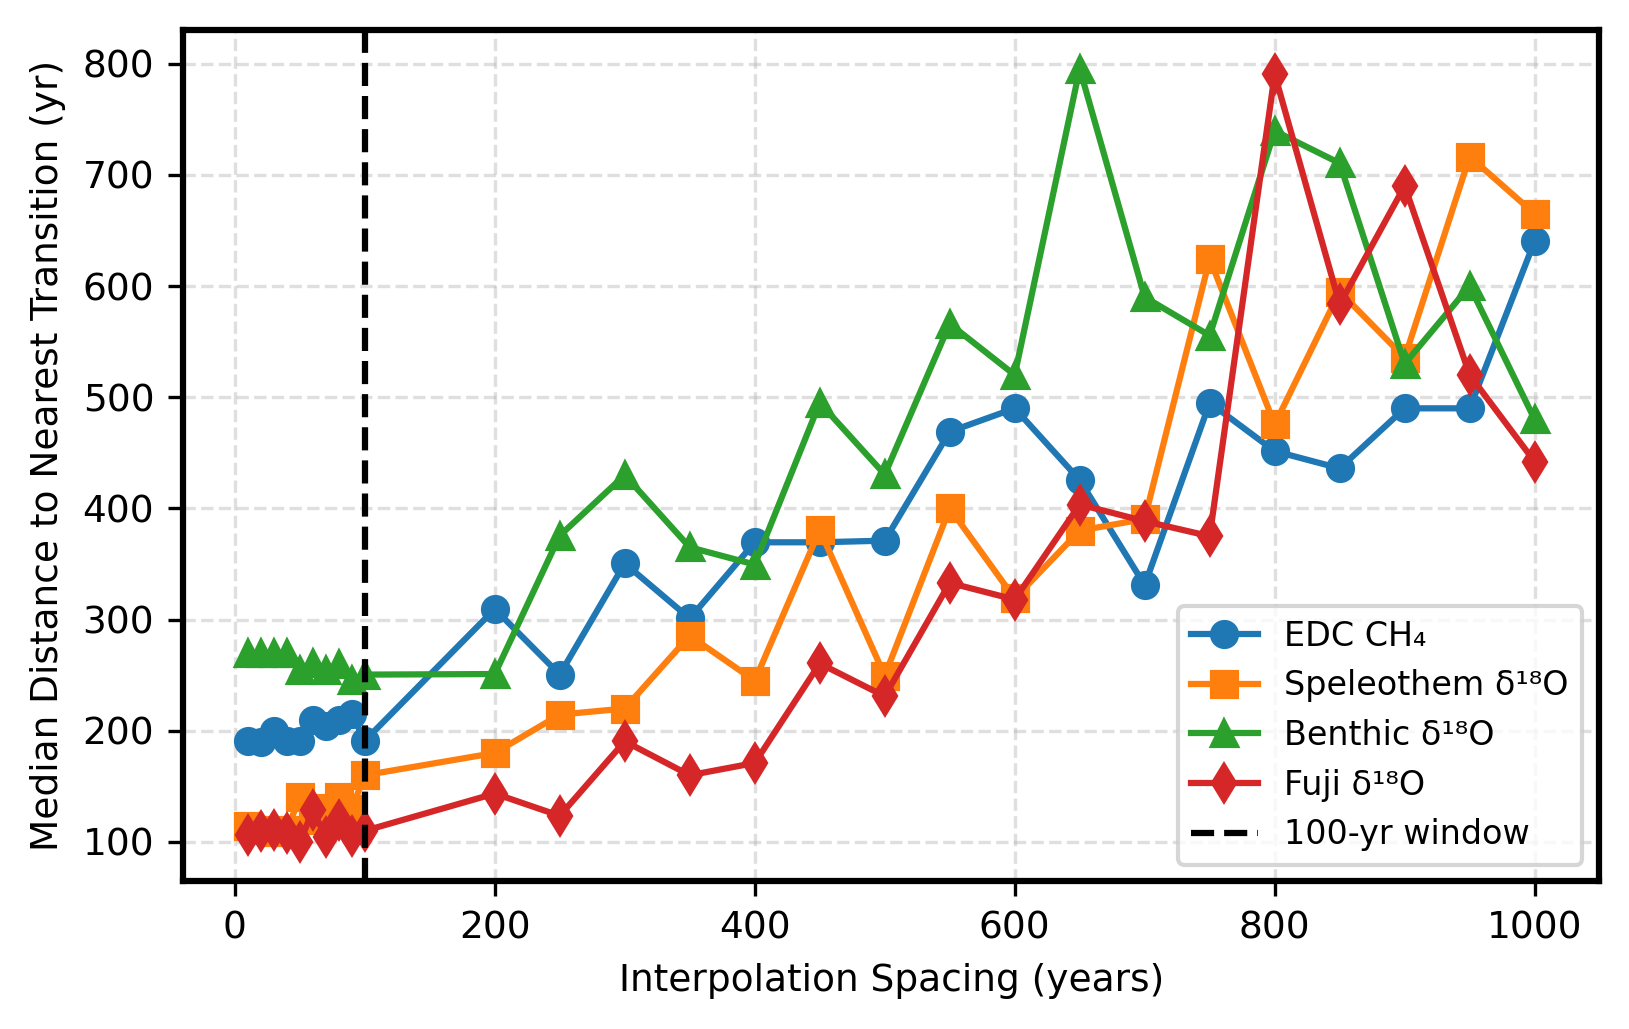

In [65]:
import numpy as np
import matplotlib.pyplot as plt

# Define interpolation window lengths: 10–100 by 10, then 200–1000 by 50
lengths = list(range(10, 101, 10)) + list(range(200, 1001, 50))

# Prepare result containers
pct_results    = {'CH4': [], 'd18O': [], 'd18O_B': [], 'd18O_fuji': []}
med_results    = {'CH4': [], 'd18O': [], 'd18O_B': [], 'd18O_fuji': []}

# Loop through each interpolation length
for L in lengths:
    # 1) Interpolate
    df1 = interpolate_df(df_filt_ch4,      L)
    df2 = interpolate_df(df_filt_d18O,     L)
    df3 = interpolate_df(df_filt_d18O_B,   L)
    df4 = interpolate_df(df_filt_d18O_fuji, L)

    # 2) Crop to age window [11703, 119140]
    df1 = df1[(df1['age'] > 11703) & (df1['age'] < 119140)]
    df2 = df2[(df2['age'] > 11703) & (df2['age'] < 119140)]
    df3 = df3[(df3['age'] > 11703) & (df3['age'] < 119140)]
    df4 = df4[(df4['age'] > 11703) & (df4['age'] < 119140)]

    # 3) Compute stats (pct_matched, _, _, median_dist)
    pct1, _, _, med1 = compute_transition_stats(df1, 'filt_ch4',    df_sq, tol=500, plot=False)
    pct2, _, _, med2 = compute_transition_stats(df2, 'filt_d18O',   df_sq, tol=500, plot=False)
    pct3, _, _, med3 = compute_transition_stats(df3, 'filt_d18O',   df_sq, tol=500, plot=False)
    pct4, _, _, med4 = compute_transition_stats(df4, 'filt_d18O',   df_sq, tol=500, plot=False)

    # 4) Store
    pct_results['CH4'].append(pct1)
    pct_results['d18O'].append(pct2)
    pct_results['d18O_B'].append(pct3)
    pct_results['d18O_fuji'].append(pct4)

    med_results['CH4'].append(med1)
    med_results['d18O'].append(med2)
    med_results['d18O_B'].append(med3)
    med_results['d18O_fuji'].append(med4)

# --- Plot percent‐matched (optional) ---
plt.figure(figsize=(5.5, 3.5), dpi=300)
plt.plot(lengths, pct_results['CH4'],    marker='o', label='EDC CH₄')
plt.plot(lengths, pct_results['d18O'],   marker='s', label='Speleothem δ¹⁸O')
plt.plot(lengths, pct_results['d18O_B'], marker='^', label='Benthic δ¹⁸O')
plt.plot(lengths, pct_results['d18O_fuji'], marker='d', label='Fuji δ¹⁸O')
plt.axvline(x=100, color='black', linestyle='--', linewidth=1.5)
for spine in plt.gca().spines.values(): spine.set_linewidth(1.5)
plt.xlabel('Interpolation Spacing (years)')
plt.ylabel('Percent Matched Transitions (%)')
plt.grid(True); plt.legend(); plt.tight_layout()
plt.show()

# --- Plot median distance vs. interpolation spacing ---
plt.figure(figsize=(5.5, 3.5), dpi=300)
plt.plot(lengths, med_results['CH4'],    marker='o', label='EDC CH₄')
plt.plot(lengths, med_results['d18O'],   marker='s', label='Speleothem δ¹⁸O')
plt.plot(lengths, med_results['d18O_B'], marker='^', label='Benthic δ¹⁸O')
plt.plot(lengths, med_results['d18O_fuji'], marker='d', label='Fuji δ¹⁸O')
plt.axvline(x=100, color='black', linestyle='--', linewidth=1.5, label='100-yr window')
for spine in plt.gca().spines.values(): spine.set_linewidth(1.5)
plt.xlabel('Interpolation Spacing (years)')
plt.ylabel('Median Distance to Nearest Transition (yr)')
plt.grid(True); plt.legend(); plt.tight_layout()
plt.show()


In [28]:
import numpy as np
import pandas as pd

def compute_phase_match(df_sq, df_data, data_col, median_val=None):
    """
    Compute how well a median-thresholded phase sequence matches NGRIP DO.

    Parameters
    ----------
    df_sq : pd.DataFrame
        Must have columns ['age','sq'], with sq==0 for stadial, 1 for interstadial.
    df_data : pd.DataFrame
        Must have columns ['age', data_col].
    data_col : str
        Name of the column in df_data to threshold (e.g. 'filt_ch4').
    median_val : float, optional
        If provided, uses this as the threshold. Otherwise uses the median of df_data[data_col].

    Returns
    -------
    metrics : dict
        'accuracy' : float
        'confusion_matrix' : pd.DataFrame  # index = ['True 0','True 1'], columns = ['Pred 0','Pred 1']
        'precision' : { 0: float, 1: float }
        'recall'    : { 0: float, 1: float }
        'f1_score'  : { 0: float, 1: float }
        'cohen_kappa' : float
        'matthews_cc' : float
    """
    # 1) Merge on age
    df_merged = pd.merge(
        df_sq[['age','sq']], 
        df_data[['age', data_col]], 
        on='age', how='inner'
    ).sort_values('age').reset_index(drop=True)

    # 2) Determine threshold
    if median_val is None:
        median_val = np.median(df_merged[data_col])

    # 3) Classify
    df_merged['pred'] = (df_merged[data_col] >= median_val).astype(int)
    df_merged['true'] = df_merged['sq'].astype(int)

    # 4) Confusion counts
    tp = int(((df_merged.pred==1) & (df_merged.true==1)).sum())
    tn = int(((df_merged.pred==0) & (df_merged.true==0)).sum())
    fp = int(((df_merged.pred==1) & (df_merged.true==0)).sum())
    fn = int(((df_merged.pred==0) & (df_merged.true==1)).sum())
    total = tp + tn + fp + fn

    # 5) Metrics
    accuracy = (tp + tn) / total if total else np.nan
    precision = {
        1: tp/(tp+fp) if (tp+fp)>0 else np.nan,
        0: tn/(tn+fn) if (tn+fn)>0 else np.nan
    }
    recall = {
        1: tp/(tp+fn) if (tp+fn)>0 else np.nan,
        0: tn/(tn+fp) if (tn+fp)>0 else np.nan
    }
    f1 = {
        k: (2*precision[k]*recall[k]/(precision[k]+recall[k]))
           if (precision[k]+recall[k])>0 else np.nan
        for k in (0,1)
    }

    # 6) Cohen's kappa
    p0 = accuracy
    p_yes = ((tp+fn)/total)*((tp+fp)/total)
    p_no  = ((tn+fp)/total)*((tn+fn)/total)
    pe = p_yes + p_no
    cohen_kappa = (p0 - pe)/(1-pe) if (1-pe)!=0 else np.nan

    # 7) Matthews correlation coefficient
    denom = np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    matthews_cc = (tp*tn - fp*fn)/denom if denom>0 else np.nan

    # 8) Confusion matrix as DataFrame
    cm = pd.DataFrame(
        [[tn, fp], [fn, tp]],
        index=['True 0','True 1'],
        columns=['Pred 0','Pred 1']
    )

    return {
        'accuracy': accuracy,
        'confusion_matrix': cm,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'cohen_kappa': cohen_kappa,
        'matthews_cc': matthews_cc
    }


In [36]:
# 1. Prepare your data
df_sq = df_sq  # has 'age','sq'
df_ch4 = df_filt_ch4.rename(columns={'filt_ch4':'CH4'})

# 2. Compute
metrics = compute_phase_match(df_sq, df_ch4, data_col='CH4')

# 3. Inspect
print("Accuracy:", metrics['accuracy'])
print("Cohen's kappa:", metrics['cohen_kappa'])
print("Matthews CC:", metrics['matthews_cc'])
print("Confusion matrix:\n", metrics['confusion_matrix'])
print("Precision:", metrics['precision'])
print("Recall:", metrics['recall'])
print("F1:", metrics['f1_score'])


Accuracy: 0.6769087523277467
Cohen's kappa: 0.35381750465549344
Matthews CC: 0.35383959202080967
Confusion matrix:
         Pred 0  Pred 1
True 0     721     341
True 1     353     733
Precision: {1: 0.6824953445065177, 0: 0.6713221601489758}
Recall: {1: 0.6749539594843462, 0: 0.6789077212806026}
F1: {0: 0.6750936329588015, 1: 0.6787037037037038}
